In [1]:
import time
import math
import csv
import pandas as pd
import seaborn as sns; sns.set()
from IPython.display import display, Math, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
import tkinter as tk
from tkinter import filedialog
import os
import importlib
%matplotlib inline

C:\Users\Matthew\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions

## Get Fibers

In [2]:
def get_fibers(side, nuclei, *argv):
    if len(argv) == 0: #No path provided
        root = tk.Tk()
        root.lift()
        root.withdraw()
        scirun_dir = filedialog.askdirectory(title='SCIRun Directory') #Select SCIRun directory
    else:
        scirun_dir = argv[0]
    #return scirun_dir
    if 'pallidum' in nuclei:
        amp_files = os.listdir(scirun_dir+'/simulations/Monopolar/'+side+'_'+nuclei.title())
    else:
        amp_files = os.listdir(scirun_dir+'/simulations/Monopolar/'+side)
    if len(amp_files) > 50:
        hardware_type = 'Medtronic'
    else:
        hardware_type = 'NeuroPace'
    fiber_names = []
    for amp in amp_files:
        amp = amp.split('_amp_')
        fiber_names.append(amp[0])
    fiber_names = np.unique(fiber_names) #only the file names
    
    dir_files = os.listdir(scirun_dir)
    pts = []
    edge = []
    fiber_files = []
    for file in dir_files:
        for name in fiber_names:
            filename = os.path.splitext(file)
            if name == filename[0] and '.edge' in file:
                edge.append(file)
                fiber_files.append(name)
            elif name == filename[0] and '.pts' in file:
                pts.append(file)
            else:
                pass
    return {'Path':scirun_dir, 'pts':pts, 'edge':edge, 'names':fiber_files, 'Hardware':hardware_type}

## Build Data Frame

In [3]:
def dataframe_build(fibers, side, stim_type, nuclei, max_scale):
    if 'Pallidum' in nuclei.title():
        sim_df = pd.read_csv(fibers['Path']+'/simulations/Monopolar/'+side+'_Pallidum/Amplitude.txt',header=None)
    else:
        sim_df = pd.read_csv(fibers['Path']+'/simulations/Monopolar/'+side+'/Amplitude.txt',header=None)
    sim_value = sim_df[0][0]
    percentActivation = []
    if 'ring' in stim_type:
        #spread = 20
        spread = max_scale*4
        contacts = [0,1,2,3]*max_scale
        #df_template = pd.read_csv("activation_df_template.csv")
        df_template = pd.read_csv("activation_df_test.csv")
    else:
        #spread = 40
        spread = max_scale*8
        contacts = [0,1,2,3,4,5,6,7]*max_scale
        df_template = pd.read_csv("activation_df_test.csv")
    for f in range(0,len(fibers['names'])):
        percentActivation = percentActivation + fiberActivation(fibers['Path'],fibers['pts'][f],fibers['edge'][f],fibers['names'][f],side, stim_type, nuclei, max_scale)
        
    df = df_template
    for f in range(0,len(fibers['names'])):
        if f > 0:
            df = pd.concat([df, df_template], ignore_index=True)
        for i in range(0,spread): #Fiber Names
            df.loc[i+(spread*f), 'Fiber_Name'] = fibers['names'][f]
            
    df.loc[0:len(percentActivation), 'Percent_Activation'] = percentActivation #values
    contacts.sort()
    df.loc[0:len(percentActivation), 'Contact'] = contacts*len(fibers['names']) #contact IDs
    '''
    sim_dec, sim_int = math.modf(sim_value)
    sim_int = int(sim_int)
    sim_dec = round(sim_dec,5)
    amp_range = list(range(1*sim_int,sim_int+max_scale))
    amp_range = [x+sim_dec for x in amp_range]
    '''
    amp_range = [abs(sim_value*x) for x in range(1,max_scale+1)]
    df.loc[0:len(percentActivation), 'Amplitude'] = amp_range*int(len(contacts)*len(fibers['names'])/max_scale)
    df.to_csv(fibers['Path']+'/simulations/activation_'+side+'_'+nuclei+'_'+stim_type+'.csv', index=False) #Save to csv
    return df

## Activating Function

In [4]:
def fiberActivation(path, pts, edge, ampVal, side, stim_type, nuclei, max_scale):
    fiberActivation = []
    m = np.loadtxt(path+'/'+edge) #edges
    linePoints = np.loadtxt(path+'/'+pts) #pts
    thresh = 0.015
    
    # Separate into idividual fibers
    lineCount = 1
    for i in range(1,len(m)):
        if m[i,0] != m[i-1,1]:
            lineCount = lineCount + 1
    lineCount = lineCount + 1
    lineEnd = np.zeros((lineCount))

    lineIndex = 0
    lineEnd[lineIndex] = 0
    for i in range(1,len(m)):
        if m[i,0] != m[i-1,1]:
            lineIndex += 1
            lineEnd[lineIndex] = i - 2 + lineIndex + 1
    lineIndex += 1
    lineEnd[lineIndex] = len(linePoints)
    try:
        open(path+'/simulations/fibercount_'+side.upper()+'.txt','r+').close()
    except:
        open(path+'/simulations/fibercount_'+side.upper()+'.txt','a').close()
        
    with open(path+'/simulations/fibercount_'+side.upper()+'.txt','r+') as f:
        for line in f:
            if ampVal in line:
                break
        else:    
            f.write(ampVal+'\t'+str(lineCount-1)+'\n')
    
    if 'ring' in stim_type: #look at ring or directional
        active_start = 0
        active_end = 4
    else:
        active_start = 4
        active_end = 12
        
    for contact in range(active_start,active_end):
        for amplitude in range(1,max_scale+1):
            scale = amplitude
            if 'pallidum' in nuclei:
                lineA = pd.read_csv(path+'/simulations/Monopolar/'+side+'_'+nuclei.title()+'/'+ampVal+'_amp_'+str(contact)+'.txt',header=None) #Fiber Current Values
            else:
                lineA = pd.read_csv(path+'/simulations/Monopolar/'+side+'/'+ampVal+'_amp_'+str(contact)+'.txt',header=None)
            lineA = np.array(lineA[0])*scale
            max_AF = np.zeros(lineCount-1)
            AFc = np.zeros((len(lineA)))
            ptVal = np.zeros((len(lineA)))
            threshPoint = np.zeros((lineCount-1,3))
            indexCounter = 0
            for l in range(1,lineCount):
                AF = np.diff(np.diff(lineA[int(lineEnd[l-1]):int(lineEnd[l])]))
                #AF[0] = 0
                #AF[-1] = 0
                if len(AF) < 1:
                    AF = [0]
                max_AF[l-1] = max(AF)
                if max(AF) > thresh:
                    ptVal[indexCounter:indexCounter+2+len(AF)] = 1
                    #print(linePoints[np.argmax(AF),0],linePoints[np.argmax(AF),1],linePoints[np.argmax(AF),2])
                    ind_max = np.argmax(AF) + indexCounter + 1
                    threshPoint[l-1,:] = linePoints[ind_max,:]
                else:
                    ptVal[indexCounter:indexCounter+2+len(AF)] = 0
                    threshPoint[l-1,:] = [np.NaN,np.NaN,np.NaN]
                    
                # Concatenate AF matricies for this fiber bundle
                #at current contact/amp
                AFc[indexCounter+1:indexCounter+1+len(AF)] = AF
                indexCounter += len(AF)+2
            
            percentActivated = len(np.argwhere(max_AF > thresh))/(lineCount-1)*100
            fiberActivation.append(percentActivated)
            
            try:
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/PT_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in ptVal])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/AF_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%.6f\n' % data for data in AFc])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/thresh_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    np.savetxt(file, threshPoint[~np.isnan(threshPoint).any(axis=1)], fmt='%.6f')
            except:
                if contact == 0:
                    os.mkdir(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal)
                os.mkdir(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact))
                
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/PT_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in ptVal])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/AF_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%.6f\n' % data for data in AFc])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/thresh_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    np.savetxt(file, threshPoint[~np.isnan(threshPoint).any(axis=1)], fmt='%.6f')
    
    return fiberActivation

 ## Charge Calculation

In [5]:
def charge_convert(amp, pulsewidth, elec_num):
    charge = []
    pulsewidth = pulsewidth / 1000000 #convert to seconds
    #current = [amp, amp*2, amp*3, amp*4, amp*5]
    current = amp
    
    for amplitude in current:
        charge.append(abs(round((1000000 * amplitude * pulsewidth) / (0.079 * elec_num),1))) #From Neuropace
        
    return charge

## Histogram Builder

In [6]:
def hist_build(convention, df_left, df_right, stim_type, nuclei):
    pd.options.mode.chained_assignment = None #hides some annoying warnings (nothing to worry about)
    df_left_sub = df_left
    df_right_sub = df_right
    
    if 'Medtronic' in convention:
        #ax_label = [-1*0.6,-2*0.6,round(-3*0.6,1),-4*0.6,-5*0.6]
        #ax_label = [-1,-2,-3,-4,-5]
        ax_label_left = list(unique(-df_left['Amplitude']))
        ax_label_left.sort(reverse=True)
        ax_label_right = list(unique(-df_right['Amplitude']))
        ax_label_right.sort(reverse=True)
        contact_prefix = 'C'
        contact_counter = 0
        x_label = 'Amplitude (mA)'
    else:
        #ax_label_left = charge_convert(-0.0003, 160, 1)
        ax_label_left = charge_convert(list(unique(df_left['Amplitude'])), 160, 1)
        #ax_label_right = charge_convert(-0.0003, 160, 1)
        ax_label_right = charge_convert(list(unique(df_right['Amplitude'])), 160, 1)
        contact_prefix = 'E'
        contact_counter = 1
        x_label = 'Amplitude (${\mu}C/cm^{2}$)'
        
    #Replace fiber names to be more readable
    fibers_old = pd.Series(df_left['Fiber_Name']).unique()
    if 'thalamus' in nuclei: 
        fibers_new = ['CL','CM','MD','VPL','VPM'] #change these when you need to
        colors = ["#253494", "#54DB81", "#F2F275", "#2c7fb8", "#47D8EA"]
    else:
        fibers_new = ['ACC','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','M1 Face','M1 Lowerex','M1 Upperex','Premotor','SMA','Prefrontal VL','Prefrontal VM']
        colors = ["#21f0b6", "#35846e", "#a8dfd4", "#23980d", "#78ee5a", "#809b31", "#c5df72", "#eb1138", "#c36785", "#fbcab9", "#c66d0e", "#f9bd3a", "#a08d7f", "#54b2fc"]
    count = 0
    for fiber_old in fibers_old:
        indices = [i for i, x in enumerate(df_left_sub['Fiber_Name']) if x == fiber_old]
        df_left_sub['Fiber_Name'][indices] = fibers_new[count] #helps set titles in the legend
        df_right_sub['Fiber_Name'][indices] = fibers_new[count]
        count += 1
    
    if 'ring' in stim_type:
        fig_size = 10
        location = [8,6,4,2] #subplot locations
        subplot_size = 4
        if 'pallidum' in nuclei:
            legend_x = 1.635
            legend_y = 0.9
        else:
            legend_x = 1.5
            legend_y = -0.5
    else:
        fig_size = 20
        location = [16,14,12,10,8,6,4,2] #subplot locations
        subplot_size = 8
        contact_labels = ['0','1a','1b','1c','2a','2b','2c','3']
        if 'pallidum' in nuclei:
            legend_x = 1.63
            legend_y = -1
        else:
            legend_x = 1.5
            legend_y = -2.8
   
    plt.rcParams['figure.figsize']=20,fig_size
    sns.set(style='white',color_codes=True)
    fig = plt.figure()
    
    
    for contact in range(0,subplot_size,1):
        df_left_sub = df_left[df_left['Contact'] == contact]
        df_right_sub = df_right[df_right['Contact'] == contact]
        if 'ring' in stim_type:
            contact_name = contact_prefix + str(contact+contact_counter) #contact labels on y axis
        else:
            contact_name = contact_labels[contact]
        #Left Side
        subp = fig.add_subplot(subplot_size,2,location[contact]-1)
        ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_left_sub)
        ax.set(ylim=(0, 100))
        ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')
        ax.yaxis.set_label_coords(-0.05,0.45)
        ax.set_xlabel('')
        ax.set_yticks([])
        if contact != 0:
            ax.set_xticks([])
        else:
            ax.set_xticklabels(ax_label_left,fontsize=25) #amplitude values
            ax.set_xlabel(x_label,fontsize=20,fontweight='bold')
        if contact == subplot_size - 1:
            ax.set_title('LEFT',fontsize=25,y=1.2,fontweight='bold')
            ax.legend(bbox_to_anchor=(legend_x,legend_y),prop={'size':25}) #legend formatting, only 1 is needed
        else:
            ax.legend_.remove()
        
        #Right Side
        subp = fig.add_subplot(subplot_size,2,location[contact])
        ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_right_sub)
        ax.set(ylim=(0, 100))
        ax.legend_.remove()
        ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')  
        ax.yaxis.set_label_coords(-0.05,0.45)
        ax.set_xlabel('')
        ax.set_yticks([])
        if contact != 0:
            ax.set_xticks([])
        else:
            ax.set_xticklabels(ax_label_right,fontsize=25)
            ax.set_xlabel(x_label,fontsize=20,fontweight='bold')
        if contact == subplot_size - 1:
            ax.set_title('RIGHT',fontsize=25,y=1.2,fontweight='bold')
            
    plt.subplots_adjust(wspace=0.7) #give more space between the plots   
    fig.text(0.06,0.5,'Percent Activation',va = 'center',rotation='vertical',fontsize=25,fontweight='bold')
    plt.show()
    return fig

# Outputs

## Ring

Using Medtronic Convention


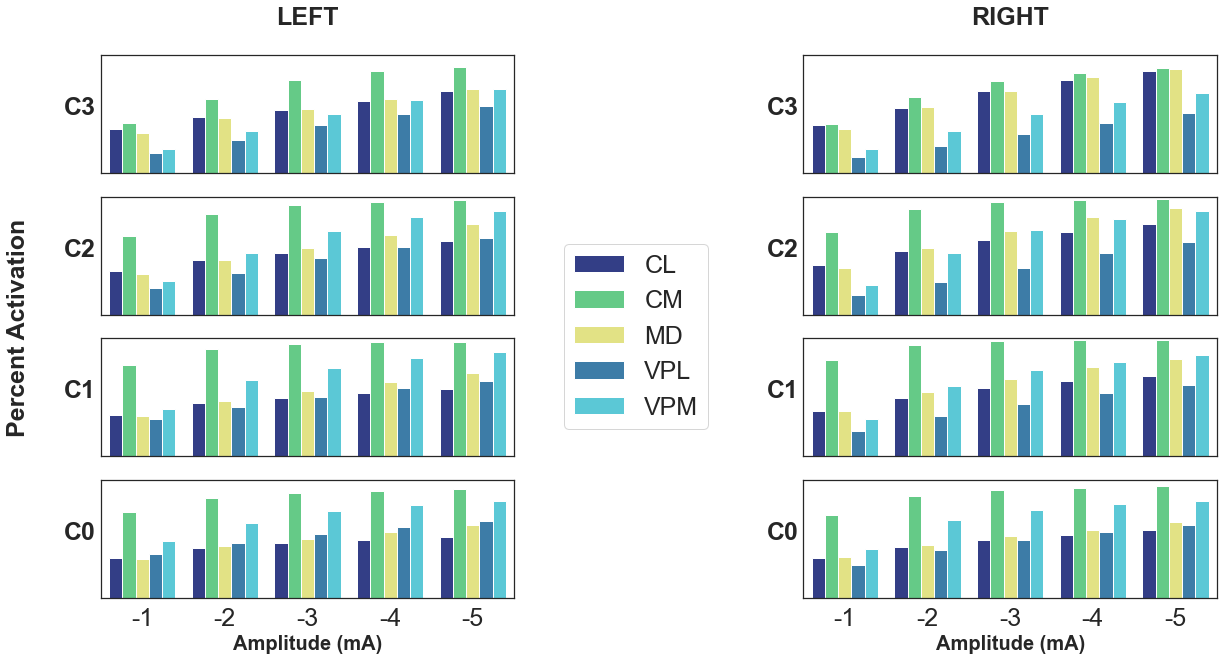

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
#Right Side
region = 'thalamus'
side = 'Right'
stim_type = 'ring'
#sim_value = 1
max_scale = 5

fibers_right = get_fibers(side, region)
scirun_dir = fibers_right['Path']
snippets_dir = scirun_dir + '/../Snippets'
print('Using', fibers_right['Hardware'], 'Convention')
df_right = dataframe_build(fibers_right, side, stim_type, region, max_scale)

#Left Side
side = 'Left'

fibers_left = get_fibers(side, region, scirun_dir)
df_left = dataframe_build(fibers_left, side, stim_type, region, max_scale)

#Build Ring Mode Histogram
fig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)

L = str(unique(df_left['Amplitude'])[0])
R = str(unique(df_right['Amplitude'])[0])

fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)
fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')

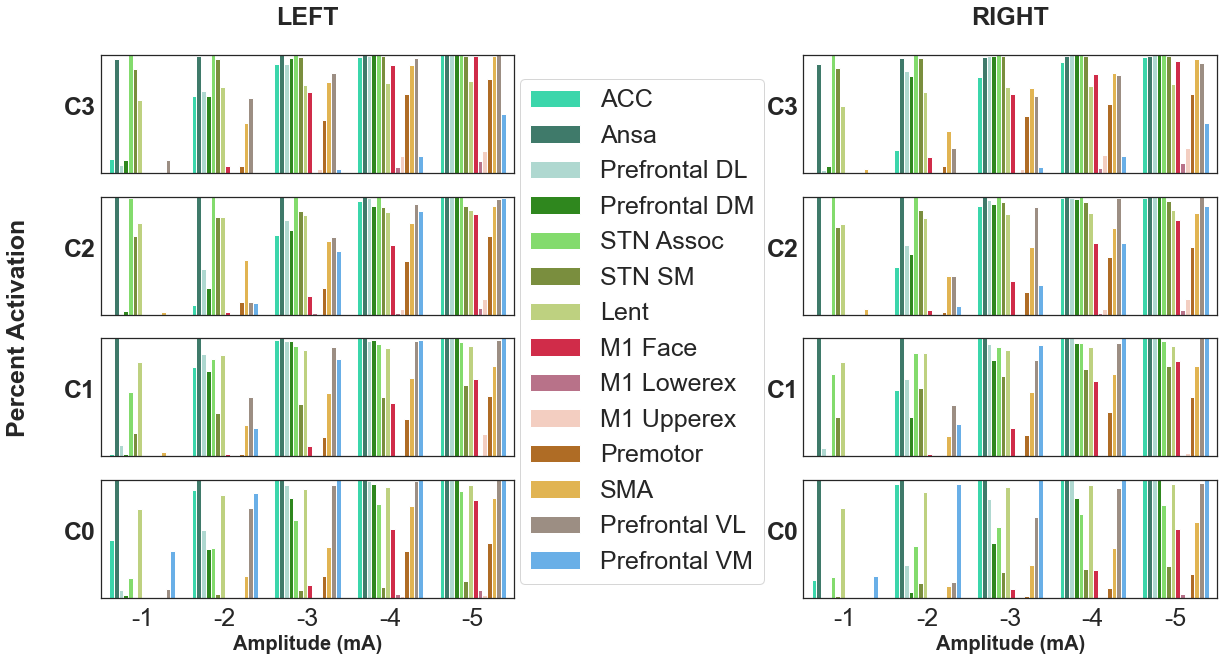

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
#Right Side
region = 'pallidum'
side = 'Right'
stim_type = 'ring'
max_scale = 5

fibers_right = get_fibers(side, region, scirun_dir)
scirun_dir = fibers_right['Path']
df_right = dataframe_build(fibers_right, side, stim_type, region, max_scale)

#Left Side
side = 'Left'

fibers_left = get_fibers(side, region, scirun_dir)
df_left = dataframe_build(fibers_left, side, stim_type, region, max_scale)

#Build Ring Mode Histogram
fig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)

L = str(unique(df_left['Amplitude'])[0])
R = str(unique(df_right['Amplitude'])[0])

fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)
fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')

## Directional

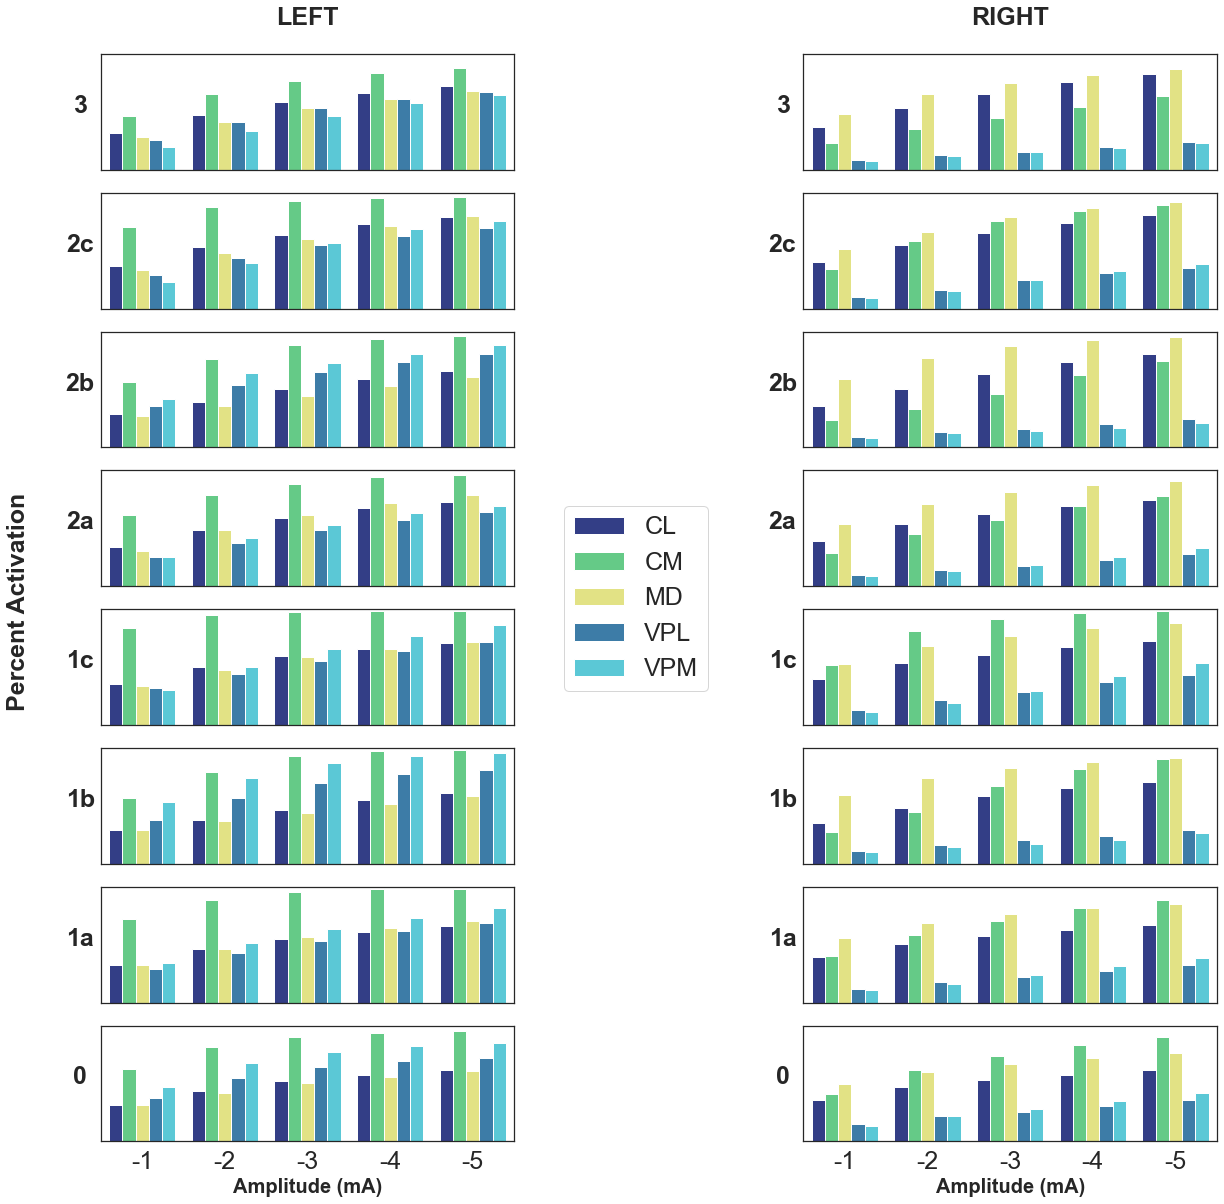

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
#Right Side
side = 'Right'
stim_type = 'directional'
region = 'thalamus'
max_scale = 5

fibers_right = get_fibers(side, region, scirun_dir)
df_right = dataframe_build(fibers_right, side, stim_type, region, max_scale)

#Left Side
side = 'Left'

fibers_left = get_fibers(side, region, scirun_dir)
df_left = dataframe_build(fibers_left, side, stim_type, region, max_scale)

#Build Ring Mode Histogram
fig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)

L = str(unique(df_left['Amplitude'])[0])
R = str(unique(df_right['Amplitude'])[0])

fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)
fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')

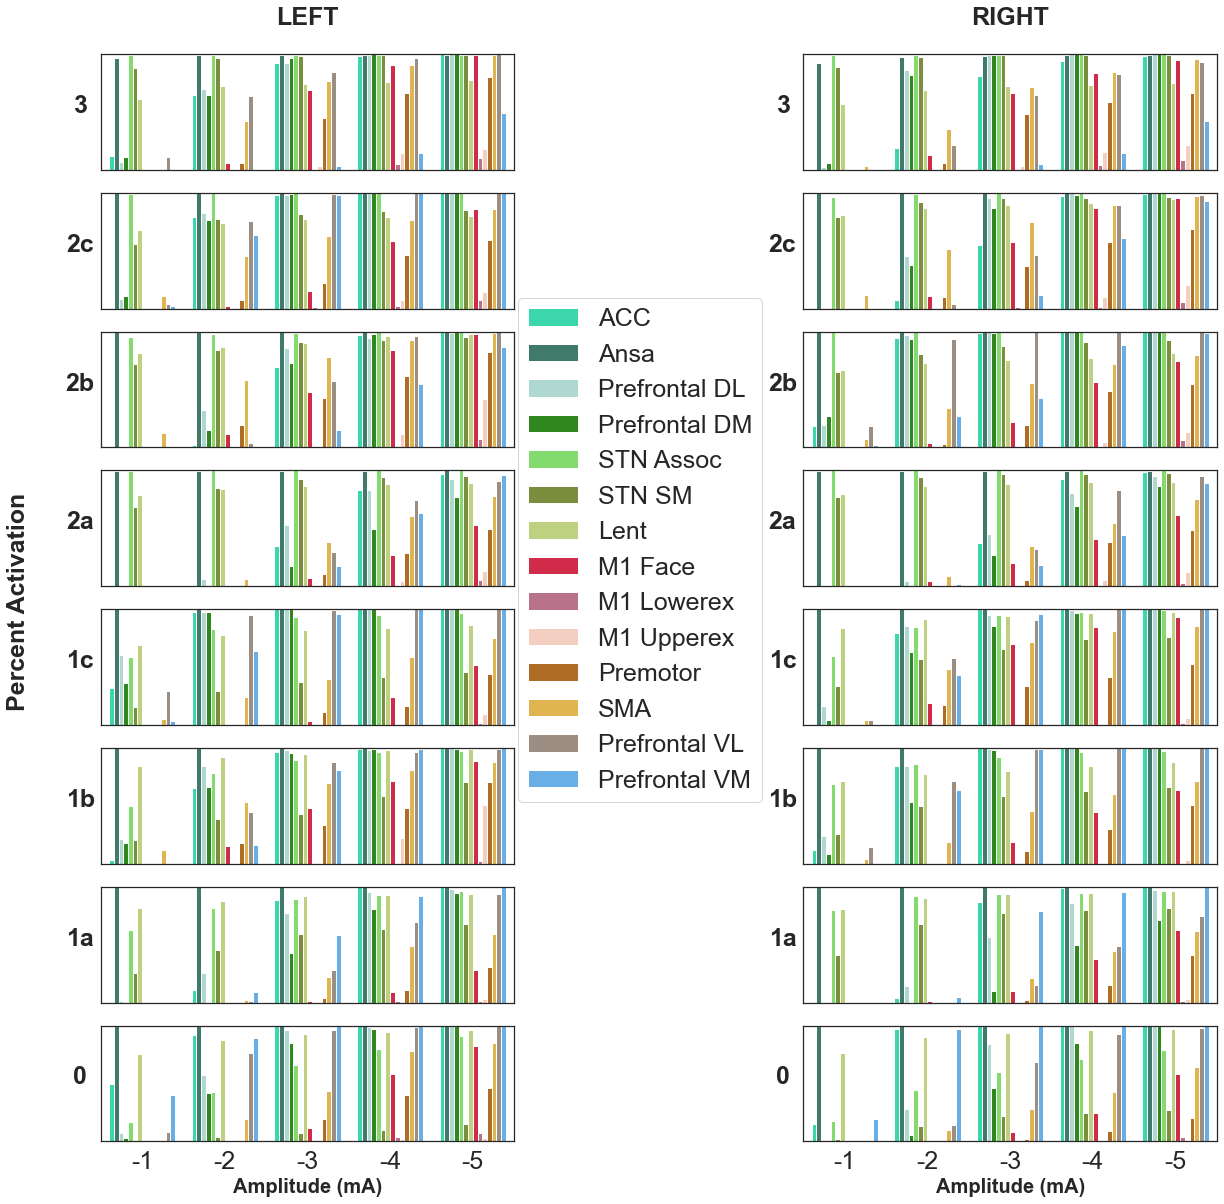

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
#Right Side
region = 'pallidum'
side = 'Right'
stim_type = 'directional'
max_scale = 5

#fibers_right = get_fibers(side, region)
fibers_right = get_fibers(side, region, scirun_dir)
scirun_dir = fibers_right['Path']
df_right = dataframe_build(fibers_right, side, stim_type, region, max_scale)

#Left Side
side = 'Left'

fibers_left = get_fibers(side, region, scirun_dir)
df_left = dataframe_build(fibers_left, side, stim_type, region, max_scale)

#Build Ring Mode Histogram
fig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)

L = str(unique(df_left['Amplitude'])[0])
R = str(unique(df_right['Amplitude'])[0])

fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)
fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')

In [16]:
print(scirun_dir)
snippets_dir = scirun_dir + '/../Snippets'
print(snippets_dir)

Z:/Dropbox (UFL)/Projects/Tourette DBS UH3/TSDBS_Data/S5/Image_processing/SCIRun
Z:/Dropbox (UFL)/Projects/Tourette DBS UH3/TSDBS_Data/S5/Image_processing/SCIRun/../Snippets


# Grouping

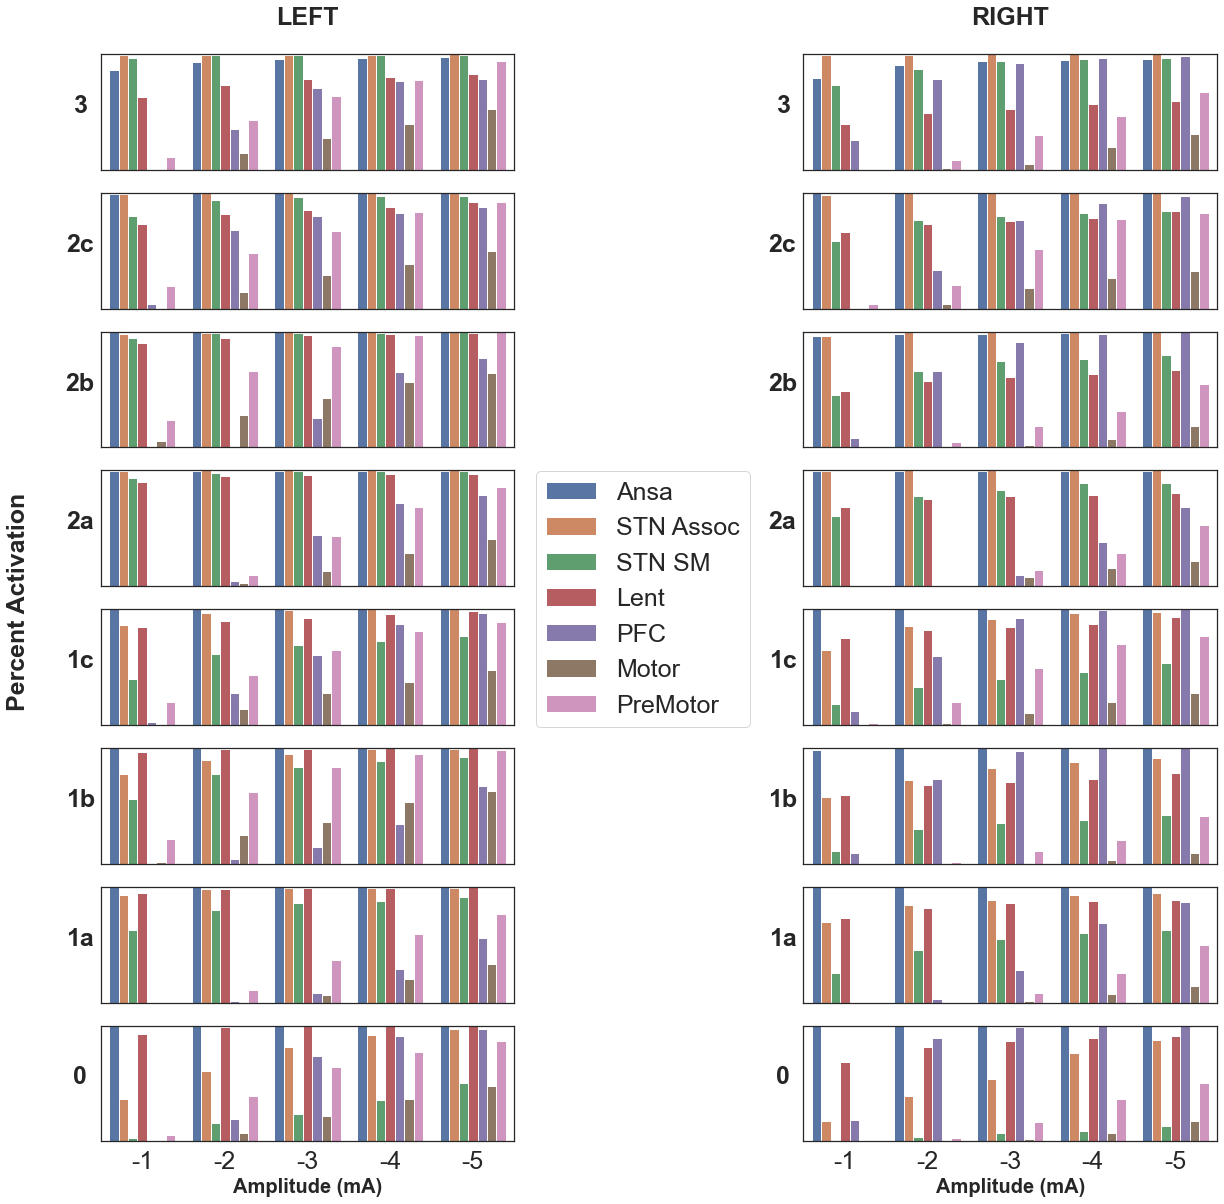

"\n#Build Ring Mode Histogram\nfig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)\n\nL = str(unique(df_left['Amplitude'])[0])\nR = str(unique(df_right['Amplitude'])[0])\n\nfig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)\nfig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')\n"

In [22]:
def fiber_grouping(df):
    amp_range = max(df['Amplitude'])
    contact_range = max(df['Contact'])
    df_condense = pd.DataFrame(columns=['Percent_Activation', 'Contact', 'Amplitude', 'Fiber_Name'])  
    df_condense_list = []
    for contact in range(0,contact_range+1):
        for amp in range(1,amp_range+1):
            PFC = {'Active':0,'Total':0}
            Motor = {'Active':0,'Total':0}
            Premotor = {'Active':0,'Total':0}
            df_looper = df.loc[(df['Contact'] == contact) & (df['Amplitude'] == amp)]
            names = df_looper['Fiber_Name']
            percent = df_looper['Percent_Activation'].tolist()
            index = 0
            for name in names:
                fiber_num = int(name.split('.')[1])
                count = (percent[index]/100 * fiber_num)
                if any([x in name for x in ['PFC','ACC']]):
                    PFC['Total'] = PFC['Total'] + fiber_num
                    PFC['Active'] = PFC['Active'] + count
                    index = index + 1
                    continue
                if any([x in name for x in ['M1']]):
                    Motor['Total'] = Motor['Total'] + fiber_num
                    Motor['Active'] = Motor['Active'] + count
                    index = index + 1
                    continue
                if any([x in name for x in ['PreMotor','SMA']]):
                    Premotor['Total'] = Premotor['Total'] + fiber_num
                    Premotor['Active'] = Premotor['Active'] + count
                    index = index + 1
                    continue
                    
                df_condense.loc[len(df_condense)] = [percent[index],contact,amp,name]
                index = index + 1
                
            PFC_percent = PFC['Active'] / PFC['Total'] * 100
            df_condense.loc[len(df_condense)] = [PFC_percent,contact,amp,'PFC']
            M_percent = Motor['Active'] / Motor['Total'] * 100
            df_condense.loc[len(df_condense)] = [M_percent,contact,amp,'Motor']
            PM_percent = Premotor['Active'] / Premotor['Total'] * 100
            df_condense.loc[len(df_condense)] = [PM_percent,contact,amp,'PreMotor']
            
            
    return df_condense
    


#Right Side
region = 'pallidum'
side = 'Right'
stim_type = 'directional'

fibers_right = get_fibers(side, region)#, scirun_dir)
scirun_dir = fibers_right['Path']
df_right_all = pd.read_csv(fibers_right['Path']+'/simulations/activation_Right_pallidum_'+stim_type+'.csv')
df_right = fiber_grouping(df_right_all)

#Left Side
side = 'Left'

fibers_left = get_fibers(side, region, scirun_dir)
df_left_all = pd.read_csv(fibers_right['Path']+'/simulations/activation_Left_pallidum_'+stim_type+'.csv')
df_left = fiber_grouping(df_left_all)

fig = hist_build_2(fibers_right['Hardware'], df_left, df_right, stim_type, region)

'''
#Build Ring Mode Histogram
fig = hist_build(fibers_right['Hardware'], df_left, df_right, stim_type, region)

L = str(unique(df_left['Amplitude'])[0])
R = str(unique(df_right['Amplitude'])[0])

fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.png', dpi=400)
fig.savefig(snippets_dir+'/Activation_histograms_'+region+'_'+stim_type+'_L'+L+'R'+R+'_scale_'+str(max_scale)+'.eps')
'''
#df_counts = fiber_grouping(df_right_all)


In [158]:
#df_counts.loc[(df_counts["Contact"] == 0) & (df_counts["Amplitude"] == 1)]
#df_counts.loc[df_counts['Fiber_Name'] == 'Sum_Right_lenticular_fasciculus.500']
df_right_all.loc[(df_right_all['Contact']==0)&(df_right_all['Amplitude']==2)]
df_counts[(df_counts['Contact']==3)&(df_counts['Amplitude']==2)]

,Percent_Activation,Contact,Amplitude,Fiber_Name
112,100.000000,3,2,Sum_Right_ansa_lenticularis.500
113,71.600000,3,2,Sum_Right_gpe2stn_ass.250
114,2.800000,3,2,Sum_Right_gpe2stn_sm.250
115,98.000000,3,2,Sum_Right_lenticular_fasciculus.500
116,89.000000,3,2,PFC
117,6.666667,3,2,Motor
118,46.500000,3,2,PreMotor


# Other

In [7]:
def hist_build_2(convention, df_left, df_right, stim_type, nuclei):
    pd.options.mode.chained_assignment = None #hides some annoying warnings (nothing to worry about)
    df_left_sub = df_left
    df_right_sub = df_right
    
    if 'Medtronic' in convention:
        #ax_label = [-1*0.6,-2*0.6,round(-3*0.6,1),-4*0.6,-5*0.6]
        #ax_label = [-1,-2,-3,-4,-5]
        ax_label_left = list(unique(-df_left['Amplitude']))
        ax_label_left.sort(reverse=True)
        ax_label_right = list(unique(-df_right['Amplitude']))
        ax_label_right.sort(reverse=True)
        contact_prefix = 'C'
        contact_counter = 0
        x_label = 'Amplitude (mA)'
    else:
        #ax_label_left = charge_convert(-0.0003, 160, 1)
        ax_label_left = charge_convert(list(unique(df_left['Amplitude'])), 160, 1)
        #ax_label_right = charge_convert(-0.0003, 160, 1)
        ax_label_right = charge_convert(list(unique(df_right['Amplitude'])), 160, 1)
        contact_prefix = 'E'
        contact_counter = 1
        x_label = 'Amplitude (${\mu}C/cm^{2}$)'
        
    #Replace fiber names to be more readable
    fibers_old = pd.Series(df_left['Fiber_Name']).unique()
    if 'thalamus' in nuclei: 
        #fibers_new = ['CL','CM','MD','VPL','VPM'] #change these when you need to
        colors = ["#253494", "#54DB81", "#F2F275", "#2c7fb8", "#47D8EA"]
    else:
        fibers_new = ['Ansa','STN Assoc','STN SM','Lent','PFC','Motor','PreMotor']
        colors = ["#21f0b6", "#35846e", "#a8dfd4", "#23980d", "#78ee5a", "#809b31", "#c5df72", "#eb1138", "#c36785", "#fbcab9", "#c66d0e", "#f9bd3a", "#a08d7f", "#54b2fc"]

    count = 0
    for fiber_old in fibers_old:
        indices = [i for i, x in enumerate(df_left_sub['Fiber_Name']) if x == fiber_old]
        df_left_sub['Fiber_Name'][indices] = fibers_new[count] #helps set titles in the legend
        df_right_sub['Fiber_Name'][indices] = fibers_new[count]
        count += 1

    if 'ring' in stim_type:
        fig_size = 10
        location = [8,6,4,2] #subplot locations
        subplot_size = 4
        if 'pallidum' in nuclei:
            legend_x = 1.6
            legend_y = -0.3 
        else:
            legend_x = 1.5
            legend_y = -0.5
    else:
        fig_size = 20
        location = [16,14,12,10,8,6,4,2] #subplot locations
        subplot_size = 8
        contact_labels = ['0','1a','1b','1c','2a','2b','2c','3']
        if 'pallidum' in nuclei:
            legend_x = 1.6
            legend_y = -2.5 #################################################################
        else:
            legend_x = 1.5
            legend_y = -2.8
   
    plt.rcParams['figure.figsize']=20,fig_size
    sns.set(style='white',color_codes=True)
    fig = plt.figure()
    
    
    for contact in range(0,subplot_size,1):
        df_left_sub = df_left[df_left['Contact'] == contact]
        df_right_sub = df_right[df_right['Contact'] == contact]
        if 'ring' in stim_type:
            contact_name = contact_prefix + str(contact+contact_counter) #contact labels on y axis
        else:
            contact_name = contact_labels[contact]
        #Left Side
        subp = fig.add_subplot(subplot_size,2,location[contact]-1)
        ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_left_sub) #palette=colors
        ax.set(ylim=(0, 100))
        ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')
        ax.yaxis.set_label_coords(-0.05,0.45)
        ax.set_xlabel('')
        ax.set_yticks([])
        if contact != 0:
            ax.set_xticks([])
        else:
            ax.set_xticklabels(ax_label_left,fontsize=25) #amplitude values
            ax.set_xlabel(x_label,fontsize=20,fontweight='bold')
        if contact == subplot_size - 1:
            ax.set_title('LEFT',fontsize=25,y=1.2,fontweight='bold')
            ax.legend(bbox_to_anchor=(legend_x,legend_y),prop={'size':25}) #legend formatting, only 1 is needed
        else:
            ax.legend_.remove()
        
        #Right Side
        subp = fig.add_subplot(subplot_size,2,location[contact])
        ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_right_sub) #palette=colors
        ax.set(ylim=(0, 100))
        ax.legend_.remove()
        ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')  
        ax.yaxis.set_label_coords(-0.05,0.45)
        ax.set_xlabel('')
        ax.set_yticks([])
        if contact != 0:
            ax.set_xticks([])
        else:
            ax.set_xticklabels(ax_label_right,fontsize=25)
            ax.set_xlabel(x_label,fontsize=20,fontweight='bold')
        if contact == subplot_size - 1:
            ax.set_title('RIGHT',fontsize=25,y=1.2,fontweight='bold')
            
    plt.subplots_adjust(wspace=0.7) #give more space between the plots   
    fig.text(0.06,0.5,'Percent Activation',va = 'center',rotation='vertical',fontsize=25,fontweight='bold')
    plt.show()
    return fig